In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
### DAVID : this is the path to my code and data folders, probably add yours

In [6]:
net = 'stepnet'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import get_T_inds, make_axes, same_stim_trial, find_ckpts,get_model_params, name_best_ckpt
from tools_lnd import plot_FP, plot_N,make_h_and_Jac, gen_trials_from_model_dir, gen_X_from_model_dir_epoch

In [41]:
model_n = 0
rule = 'contextdelaydm1'
if net is 'stepnet':
    dir_specific_all = 'crystals/softplus/l2w0001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
elif net is 'highd_inputs':
    dir_specific_all = 'crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

In [42]:
fldr = os.path.join('training_progress',dir_specific_all)
if not os.path.exists(fldr):
    os.makedirs(fldr)

In [43]:
#dim recuction in output space
model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    # get hparams
    hparams = model.hp
    # create a trial
    trial_all = generate_trials('delaygo', hparams, mode='random', noise_on=False, batch_size=1000,delay_fac = 1)# get feed_dict
    feed_dict = tools.gen_feed_dict(model, trial_all, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron) 

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model resto

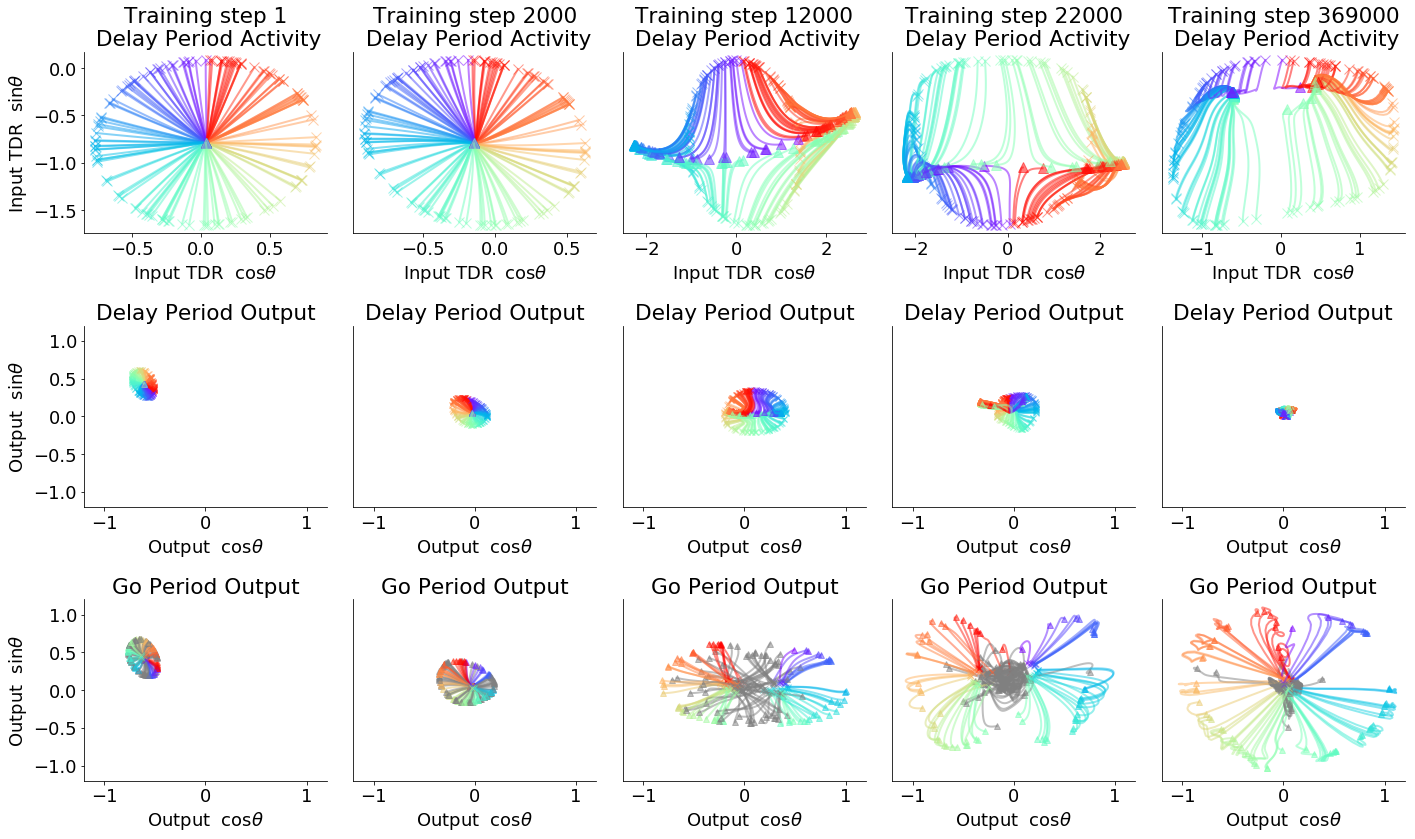

In [44]:
file_name = 'pca on go period'
epoch1 = 'stim1'
epoch2 = 'delay1'
rule_list = [18]
rule = 'dmcgo'

ckpt_n = name_best_ckpt(model_dir_all,rule)
s_all = np.sort(find_ckpts(model_dir_all))
ind_set = range(0,len(s_all),int(len(s_all)/3))
ind_set = [0, 10, 20, 30]
adj = 4

nr = 3
train_step_list = np.concatenate((s_all[ind_set],[ckpt_n]))
fig = plt.figure(figsize=(adj*len(train_step_list),nr*adj),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 18})
trial_all = gen_trials_from_model_dir(model_dir_all,'delaygo')
trial_dmc = gen_trials_from_model_dir(model_dir_all,rule)
cmap=plt.get_cmap('rainbow')

for rule1_ind in range(len(rule_list)):
        rule_num = rule_list[rule1_ind] 

        #MULTI
        model = Model(model_dir_all)
        for ckpt_indn in range(len(train_step_list)):
            ckpt_n = train_step_list[ckpt_indn]
            ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
            D = make_axes(model_dir_all,ckpt_n_dir,rule,'stim1')
            
            #dim recuction in output space
            model = Model(model_dir_all)
            with tf.Session() as sess:
                model.saver.restore(sess,ckpt_n_dir)
                model._sigma=0
                # get all connection weights and biases as tensorflow variables
                var_list = model.var_list
                # evaluate the parameters after training
                params = [sess.run(var) for var in var_list]
                # get hparams
                hparams = model.hp
                # create a trial
                trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size=1000,delay_fac = 1)# get feed_dict
                feed_dict = tools.gen_feed_dict(model, trial, hparams)
                # run model
                h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron) 

            T,S,N = np.shape(h_tf) # neurons x trials (stim)    
            epoch_inds = range(trial.epochs[epoch2][0],trial.epochs[epoch2][1]) 
            go_inds = range(trial.epochs[epoch2][1],np.shape(y_hat_tf)[0])    
            pc1 = 0
            pc2 = 1
            
            for t in range(0,S,8):
                stim1_locs = np.min(trial.stim_locs[t,[0,2]])
                c_stim1 = cmap(stim1_locs/(2*np.pi))
                c_go = cmap(trial.y_loc[-1,t]/(2*np.pi))
                if trial.y_loc[-1,t]/(2*np.pi)<0:
                    c_go = 'gray'
                
                ax1 = plt.subplot(nr,len(train_step_list),ckpt_indn+1)
                
                X2_trajectory = np.dot(h_tf[epoch_inds,t,:],D)
                plt.plot(X2_trajectory[0,pc1],X2_trajectory[0,pc2],'x',markersize = 10,c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(X2_trajectory[-1,pc1],X2_trajectory[-1,pc2],'^',markersize = 10,c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(X2_trajectory[:,pc1],X2_trajectory[:,pc2],c = c_stim1,alpha = .5,linewidth = 2)
                
                plt.xlabel('Input TDR ' + r' $\cos{\theta}$')
                if ckpt_indn==0:
                    plt.ylabel('Input TDR ' + r' $\sin{\theta}$') 
                else:
                    ax1.get_yaxis().set_visible(False)
                ax1.spines['right'].set_visible(False)
                ax1.spines['top'].set_visible(False)
                plt.title('Training step '+str(ckpt_n) + '\n Delay Period Activity')
                
                
                ax2 = plt.subplot(nr,len(train_step_list),ckpt_indn+1+len(train_step_list))
                plt.plot(y_hat_tf[epoch_inds,t,1],y_hat_tf[epoch_inds,t,2],c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[epoch_inds[0],t,1],y_hat_tf[epoch_inds[0],t,2],'x',c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[epoch_inds[-1],t,1],y_hat_tf[epoch_inds[-1],t,2],'^',c = c_stim1,alpha = .5,linewidth = 2)
                plt.ylim((-1.2,1.2))
                plt.xlim((-1.2,1.2))
                
                plt.title('Delay Period Output')
                plt.xlabel('Output ' + r' $\cos{\theta}$')
                if ckpt_indn==0:
                    plt.ylabel('Output ' + r' $\sin{\theta}$')
                else:
                    ax2.get_yaxis().set_visible(False)
                ax2.spines['right'].set_visible(False)
                ax2.spines['top'].set_visible(False)
                
                ax3 = plt.subplot(nr,len(train_step_list),ckpt_indn+1+2*len(train_step_list))
                plt.plot(y_hat_tf[go_inds,t,1],y_hat_tf[go_inds,t,2],c = c_go,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[go_inds[0],t,1],y_hat_tf[go_inds[0],t,2],'x',c = c_go,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[go_inds[-1],t,1],y_hat_tf[go_inds[-1],t,2],'^',c = c_go,alpha = .5,linewidth = 2)
                plt.ylim((-1.2,1.2))
                plt.xlim((-1.2,1.2))
                
                plt.title('Go Period Output')
                plt.xlabel('Output ' + r' $\cos{\theta}$')
                if ckpt_indn==0:
                    plt.ylabel('Output ' + r' $\sin{\theta}$')
                else:
                    ax3.get_yaxis().set_visible(False) 
                ax3.spines['right'].set_visible(False)
                ax3.spines['top'].set_visible(False)
            
figpath = os.path.join(model_dir_all,'training_progress',rule)
figname = rule+'_'+epoch2+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model resto

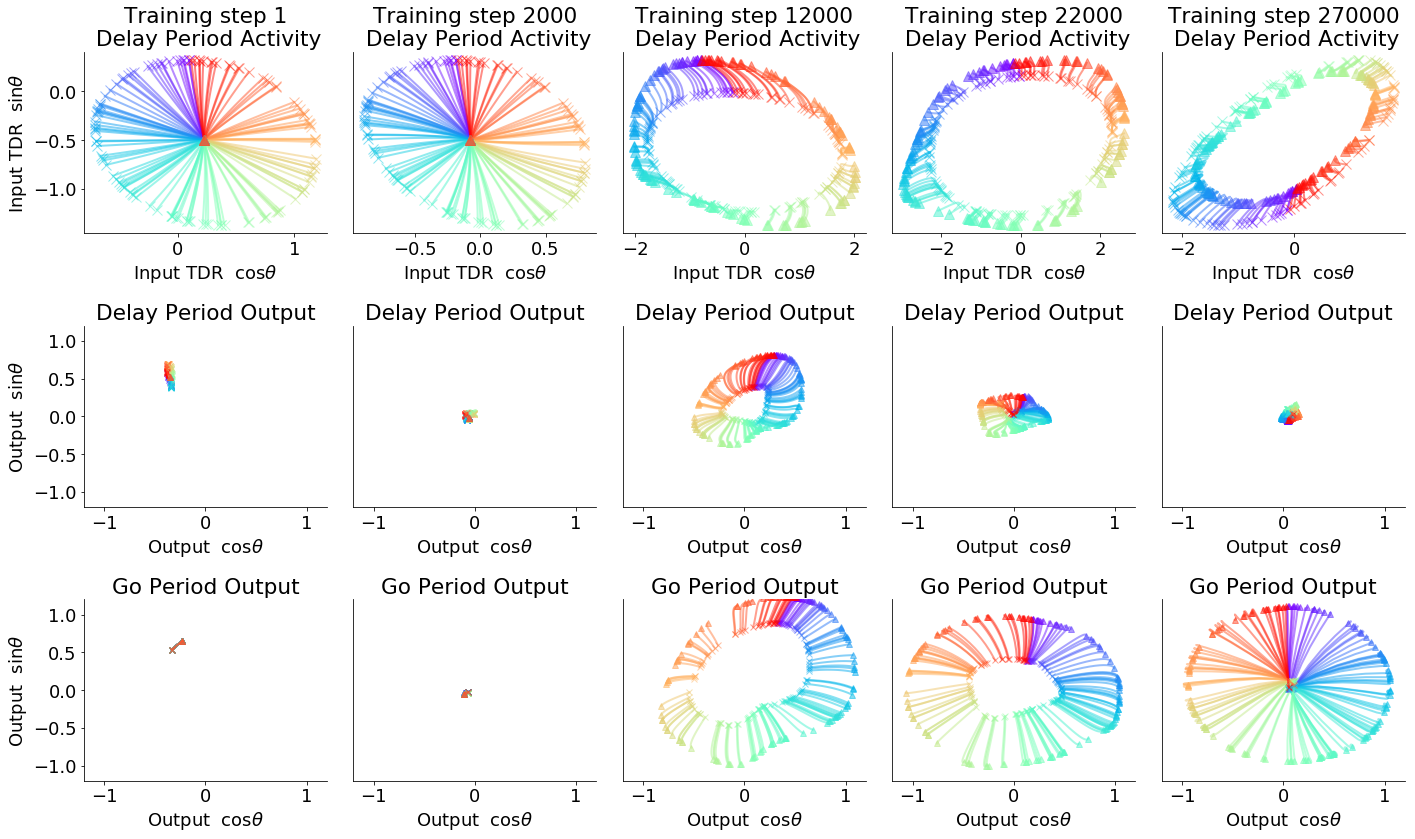

In [45]:
file_name = 'pca on go period'
epoch1 = 'stim1'
epoch2 = 'delay1'
rule_list = [18]
rule = 'delaygo'

ckpt_n = name_best_ckpt(model_dir_all,rule)
s_all = np.sort(find_ckpts(model_dir_all))
ind_set = range(0,len(s_all),int(len(s_all)/3))
ind_set = [0, 10, 20, 30]
adj = 4

nr = 3
train_step_list = np.concatenate((s_all[ind_set],[ckpt_n]))
fig = plt.figure(figsize=(adj*len(train_step_list),nr*adj),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 18})
trial_all = gen_trials_from_model_dir(model_dir_all,'delaygo')
trial_dmc = gen_trials_from_model_dir(model_dir_all,rule)
cmap=plt.get_cmap('rainbow')

for rule1_ind in range(len(rule_list)):
        rule_num = rule_list[rule1_ind] 

        #MULTI
        model = Model(model_dir_all)
        for ckpt_indn in range(len(train_step_list)):
            ckpt_n = train_step_list[ckpt_indn]
            ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
            D = make_axes(model_dir_all,ckpt_n_dir,rule,'stim1')
            
            #dim recuction in output space
            model = Model(model_dir_all)
            with tf.Session() as sess:
                model.saver.restore(sess,ckpt_n_dir)
                model._sigma=0
                # get all connection weights and biases as tensorflow variables
                var_list = model.var_list
                # evaluate the parameters after training
                params = [sess.run(var) for var in var_list]
                # get hparams
                hparams = model.hp
                # create a trial
                trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size=1000,delay_fac = 1)# get feed_dict
                feed_dict = tools.gen_feed_dict(model, trial, hparams)
                # run model
                h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron) 

            T,S,N = np.shape(h_tf) # neurons x trials (stim)    
            epoch_inds = range(trial.epochs[epoch2][0],trial.epochs[epoch2][1]) 
            go_inds = range(trial.epochs[epoch2][1],np.shape(y_hat_tf)[0])    
            pc1 = 0
            pc2 = 1
            
            for t in range(0,S,8):
                stim1_locs = np.min(trial.stim_locs[t,[0,2]])
                c_stim1 = cmap(stim1_locs/(2*np.pi))
                c_go = cmap(trial.y_loc[-1,t]/(2*np.pi))
                if trial.y_loc[-1,t]/(2*np.pi)<0:
                    c_go = 'gray'
                
                ax1 = plt.subplot(nr,len(train_step_list),ckpt_indn+1)
                
                X2_trajectory = np.dot(h_tf[epoch_inds,t,:],D)
                plt.plot(X2_trajectory[0,pc1],X2_trajectory[0,pc2],'x',markersize = 10,c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(X2_trajectory[-1,pc1],X2_trajectory[-1,pc2],'^',markersize = 10,c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(X2_trajectory[:,pc1],X2_trajectory[:,pc2],c = c_stim1,alpha = .5,linewidth = 2)
                
                plt.xlabel('Input TDR ' + r' $\cos{\theta}$')
                if ckpt_indn==0:
                    plt.ylabel('Input TDR ' + r' $\sin{\theta}$') 
                else:
                    ax1.get_yaxis().set_visible(False)
                ax1.spines['right'].set_visible(False)
                ax1.spines['top'].set_visible(False)
                plt.title('Training step '+str(ckpt_n) + '\n Delay Period Activity')
                
                
                ax2 = plt.subplot(nr,len(train_step_list),ckpt_indn+1+len(train_step_list))
                plt.plot(y_hat_tf[epoch_inds,t,1],y_hat_tf[epoch_inds,t,2],c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[epoch_inds[0],t,1],y_hat_tf[epoch_inds[0],t,2],'x',c = c_stim1,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[epoch_inds[-1],t,1],y_hat_tf[epoch_inds[-1],t,2],'^',c = c_stim1,alpha = .5,linewidth = 2)
                plt.ylim((-1.2,1.2))
                plt.xlim((-1.2,1.2))
                
                plt.title('Delay Period Output')
                plt.xlabel('Output ' + r' $\cos{\theta}$')
                if ckpt_indn==0:
                    plt.ylabel('Output ' + r' $\sin{\theta}$')
                else:
                    ax2.get_yaxis().set_visible(False)
                ax2.spines['right'].set_visible(False)
                ax2.spines['top'].set_visible(False)
                
                ax3 = plt.subplot(nr,len(train_step_list),ckpt_indn+1+2*len(train_step_list))
                plt.plot(y_hat_tf[go_inds,t,1],y_hat_tf[go_inds,t,2],c = c_go,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[go_inds[0],t,1],y_hat_tf[go_inds[0],t,2],'x',c = c_go,alpha = .5,linewidth = 2)
                plt.plot(y_hat_tf[go_inds[-1],t,1],y_hat_tf[go_inds[-1],t,2],'^',c = c_go,alpha = .5,linewidth = 2)
                plt.ylim((-1.2,1.2))
                plt.xlim((-1.2,1.2))
                
                plt.title('Go Period Output')
                plt.xlabel('Output ' + r' $\cos{\theta}$')
                if ckpt_indn==0:
                    plt.ylabel('Output ' + r' $\sin{\theta}$')
                else:
                    ax3.get_yaxis().set_visible(False) 
                ax3.spines['right'].set_visible(False)
                ax3.spines['top'].set_visible(False)
            
figpath = os.path.join(model_dir_all,'training_progress',rule)
figname = rule+'_'+epoch2+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2w0001/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bia

<Figure size 360x360 with 0 Axes>

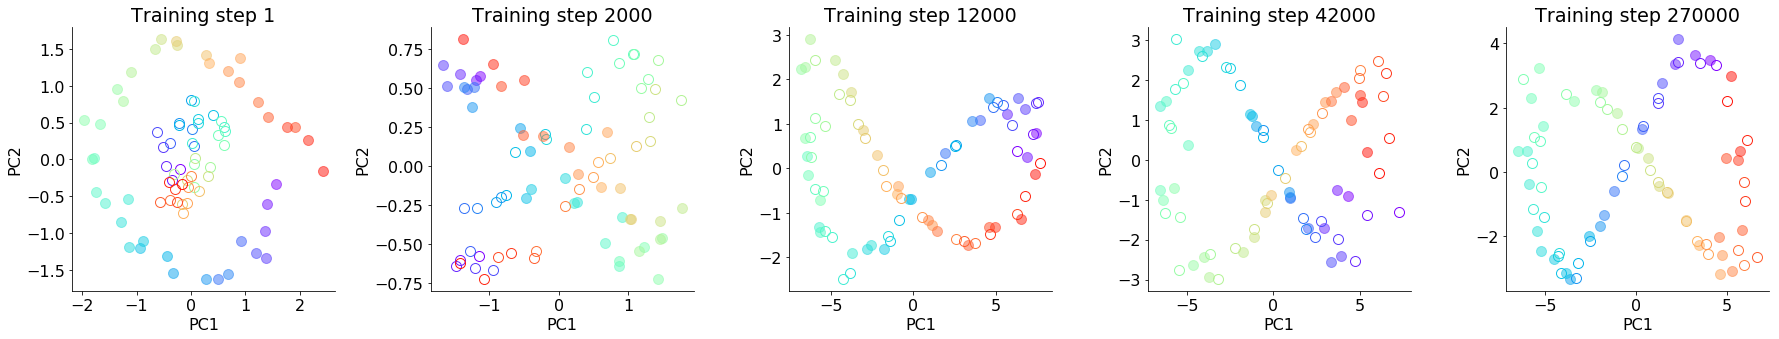

In [46]:
fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
file_name = 'pca on go period'
epoch = 'stim1'
rule_list = [2]
ind_set = range(0,200,10)
ckpt_n = name_best_ckpt(model_dir_all,'delaygo')
inds = [0,1,2,5,-1]
train_step_list = np.concatenate((s_all[ind_set],[ckpt_n]))[inds]
fig = plt.figure(figsize=(5*len(plt_ckpts),5),tight_layout=True,facecolor='white')
trial_all = gen_trials_from_model_dir(model_dir_all,'delaygo')

for rule1_ind in range(1):
        rule1 = rule_list[rule1_ind]
#         rule2 = rule_list[rule1_ind+1]

        #MULTI
        model = Model(model_dir_all)
        for ckpt_indn in range(len(train_step_list)):
            ckpt_n = train_step_list[ckpt_indn]
            ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

            trial1 = same_stim_trial(trial_all, rule1)
            X1,x1 = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial1,epoch)
            
#             trial2 = same_stim_trial(trial_all, rule2)
#             X2,x2 = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial2,epoch)

            X = x1[:,:,-1]#np.concatenate((x2[:,:,-1],x2[:,:,-1]),axis = 1)
            N,S,T = np.shape(x1) # neurons x trials (stim)  
            pca = PCA()
            X_pca = pca.fit_transform(X.T)
            X1_pca = pca.transform(x1[:,:,-1].T)
#             X2_pca = pca.transform(x2[:,:,-1].T)

            n_pcs = 5
            cmap=plt.get_cmap('rainbow')
            
            ax1 = plt.subplot(1,len(train_step_list),ckpt_indn+1)
            pc1 = 0
            pc2 = 2
            for t in range(0,S,2):
                c = cmap(t/S)
                
                plt.plot(X1_pca[t,pc1],X1_pca[t,pc2],'o',markersize = 10,fillstyle = 'none',c = c)
                plt.plot(X1_pca[t+1,pc1],X1_pca[t+1,pc2],'o',markersize = 10,c = c,alpha = .5)

                plt.xlabel('PC1')
                plt.ylabel('PC2')
                plt.title('Training step '+str(ckpt_n))

            ax1.spines['right'].set_visible(False)
            ax1.spines['top'].set_visible(False)
            
figpath = os.path.join(model_dir_all,'training_progress',rule)
figname = rules_dict['all'][rule1]+'_mod_1_2.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()